# Regression Modeling Demo

In this notebook, we provide a solution to find a hidden model and predict the target feature. We present it in 4 sections:

1. Understanding the problem
2. Exploratory Data Analysis (EDA)
3. Build the models and validation
4. Predict values from the blind dataset

## 1. Understanding the problem

In this section, we read the data we have, put them in context and try to build preliminar hypothesis. They are very useful to not get lost in the data, specially when the number of features is very large.

In [1]:
# Import libraries and functions
import io
import numpy as np
import pandas as pd
import tarfile
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.stats import norm, skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


Let's see the contents of the <code>tar.gz</code> file and load training and blind test datasets.

In [2]:
# Check names of the files
dataset_path = Path("../data/data science ml modeling challenge (1).tar.gz")
dataset = tarfile.open(dataset_path)
dataset_files = dataset.getmembers()
dataset_files

[<TarInfo '._blind_test_data.csv' at 0x7f22e470e440>,
 <TarInfo 'blind_test_data.csv' at 0x7f22920eac80>,
 <TarInfo '._training_data.csv' at 0x7f22920ea2c0>,
 <TarInfo 'training_data.csv' at 0x7f22920ead40>]

In [3]:
# Load data in a Pandas DataFrame
data = pd.read_csv(io.BytesIO(dataset.extractfile(dataset_files[3].name).read()), encoding="utf8")
data_blind_test = pd.read_csv(io.BytesIO(dataset.extractfile(dataset_files[1].name).read()), encoding="utf8")
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,432.475954,289.373016,481.315600,358.755566,802.659004,176.761177,72.648102,720.969179,36.327684,83.768878,...,4.385848,516.789458,19.624422,13.162440,42.351948,35.920392,20.755984,13.814300,384.497136,14.364922
1,517.596250,330.448341,585.920055,22.684031,169.813240,335.601640,284.451476,748.101047,73.701438,358.147215,...,5.563334,2.960064,20.721878,17.740184,1.726915,167.576065,75.492679,2.480979,303.710869,19.984801
2,189.439350,553.888820,165.833790,202.465927,176.695586,321.155049,407.278389,161.245668,282.269025,221.570899,...,4.536947,581.823741,101.695639,0.653592,486.859084,117.491548,6.420465,20.713314,22.651537,12.944351
3,237.307878,195.894881,416.752252,468.729031,611.693517,301.411711,241.880655,49.597044,122.396821,13.828319,...,5.518968,45.014729,196.350455,47.638515,411.414213,67.142022,115.630943,8.927957,388.240433,14.792440
4,602.845256,16.103208,221.759979,345.765574,558.588369,276.704241,408.069566,19.390813,138.769765,146.662193,...,2.136214,133.590430,197.634584,26.278027,111.127557,172.181136,85.869642,30.537857,625.931837,11.802634


In [4]:
# Check table information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   800 non-null    float64
 1   feature_1   800 non-null    float64
 2   feature_2   800 non-null    float64
 3   feature_3   800 non-null    float64
 4   feature_4   800 non-null    float64
 5   feature_5   800 non-null    float64
 6   feature_6   800 non-null    float64
 7   feature_7   800 non-null    float64
 8   feature_8   800 non-null    float64
 9   feature_9   800 non-null    float64
 10  feature_10  800 non-null    float64
 11  feature_11  800 non-null    float64
 12  feature_12  800 non-null    float64
 13  feature_13  800 non-null    float64
 14  feature_14  800 non-null    float64
 15  feature_15  800 non-null    float64
 16  feature_16  800 non-null    float64
 17  feature_17  800 non-null    float64
 18  feature_18  800 non-null    float64
 19  feature_19  800 non-null    f

Following the information extracted from the table, there are no null data and all columns are floating values. One previous step before starting the EDA would be to build hypothesis to tackle the problem and find correlations with the target feature. In this case, as the features have no physical meaning, we cannot build such hypothesis and we will work directly with the available data.

# 2. Exploratory Data Analysis (EDA)

To start our analysis, we will see how the data is distributed in numbers and we will make some plots to visualize it. It is useful to use the method <code>describe()</code> to check the basic statistics.

In [5]:
# Describe data
data.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,468.181612,301.960218,317.132996,283.213456,485.975950,320.953859,217.136330,387.196289,179.485453,196.003058,...,3.372667,479.841915,100.112096,28.334725,277.205999,91.217615,70.927129,27.385266,457.016407,14.631342
std,270.797415,170.691136,176.501920,157.698215,272.594030,185.157189,123.660691,235.131376,104.059309,111.042671,...,1.986369,276.304197,59.149794,16.105155,167.385930,53.950523,40.588905,15.509062,270.650146,5.089503
min,0.916648,0.800119,0.173025,0.308823,0.598527,0.997347,0.402436,0.474825,0.727850,0.264253,...,0.004464,1.706240,0.194306,0.222312,1.726915,0.093789,0.072986,0.101761,0.252919,0.279805
25%,239.330140,157.338244,167.516318,151.302826,250.305362,158.374610,106.876625,195.037853,94.220273,95.052359,...,1.630150,249.560260,48.132939,14.660437,131.516567,44.357970,34.903031,13.815298,221.270792,10.879914
50%,477.750620,303.257176,326.310194,294.574403,493.470486,328.722464,217.098090,364.124238,173.364771,199.587048,...,3.349497,468.536888,100.247827,27.953146,275.950814,87.484343,74.429675,27.766111,462.153497,14.687955
75%,704.650292,448.878174,474.484472,415.806162,720.747672,480.076559,327.411334,588.565017,268.790459,291.546642,...,5.024192,713.291136,149.966755,42.514155,423.110446,137.888018,105.484961,40.402938,688.352373,18.224713
max,940.771543,595.359858,614.271632,549.896216,950.017444,638.199832,426.308251,809.346792,367.084755,384.919108,...,6.859269,979.715063,203.122292,56.467485,566.611509,187.041256,138.675389,53.254740,935.740775,27.360789


We can see there is almost no presence of outliers, because the <code>min</code> and <code>max</code> of all features in general fall inside the interquantile range. The standard deviation is quite large in general with respect the mean, thus we would expect some level of dispersion.

Let's calculate the skewness to see if there are asymmetries in the data. This step is important to avoid problems to fulfill the conditions of linearity, independence, normality and homocedasticity in the residuals.

In [6]:
# Calculate skewness
data.skew()

feature_0    -0.006914
feature_1    -0.020664
feature_2    -0.095685
feature_3    -0.127456
feature_4    -0.007777
feature_5    -0.000799
feature_6    -0.007109
feature_7     0.126732
feature_8     0.066990
feature_9    -0.009713
feature_10   -0.099994
feature_11    0.047312
feature_12    0.051155
feature_13    0.074751
feature_14   -0.028775
feature_15    0.056576
feature_16    0.077813
feature_17   -0.062852
feature_18   -0.058970
feature_19   -0.004155
target       -0.039838
dtype: float64

Skewness looks good. Let's plot the histograms to observe how features are distributed.

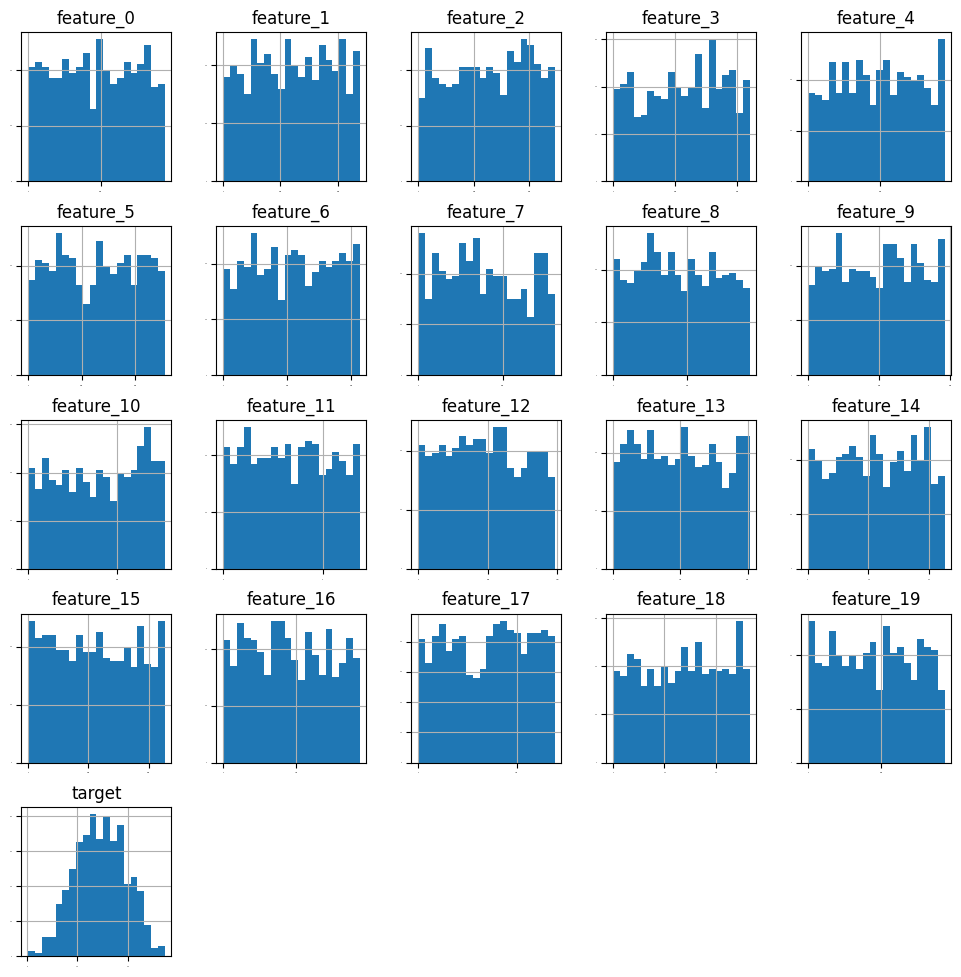

In [7]:
# Plot histograms
data.hist(bins=20, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
plt.show()

All features with the exception of the target seem to be quite close to an uniform distribution. The target feature has a more normal shape. We confirm this using kurtosis.

In [8]:
data.kurt()

feature_0    -1.209709
feature_1    -1.188703
feature_2    -1.197312
feature_3    -1.160412
feature_4    -1.169019
feature_5    -1.253601
feature_6    -1.224759
feature_7    -1.154860
feature_8    -1.163720
feature_9    -1.192649
feature_10   -1.284245
feature_11   -1.183061
feature_12   -1.135095
feature_13   -1.210136
feature_14   -1.192480
feature_15   -1.225903
feature_16   -1.178781
feature_17   -1.235720
feature_18   -1.209800
feature_19   -1.200382
target       -0.540187
dtype: float64

All features are platykurtic, except the target feature which is closer to 0, much closer to a normal distribution.

Now, we want to see if there is correlation between features. Correlated features are providing redundant information, therefore if we find a couple of correlated features, we can use only 1. Of course, this is not the case if the correlation happens with the target. The latter case is the best result we can get.

<AxesSubplot: title={'center': 'Correlation Matrix'}>

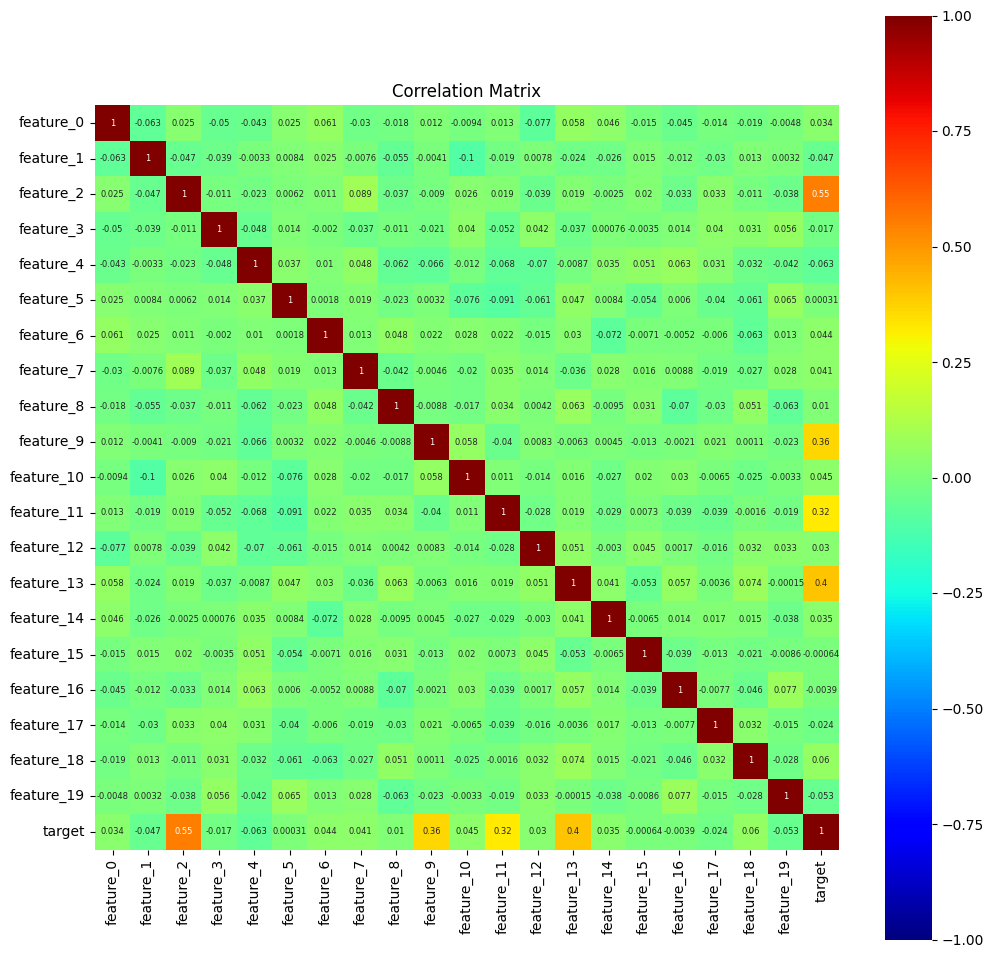

In [9]:
# Calculate cross-correlations
correlation = data.corr()
plt.figure(figsize=(12, 12))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, vmin=-1, square=True, annot=True, annot_kws={"fontsize": 6}, cmap='jet')

Correlation between features is very low in general, with the exception of <code>feature_2</code> with <code>target</code>, where the correlation is slightly higher than 0.5. Taking into account the number of samples, it is very significant. Other features with outlined correlation with <code>target</code> are <code>feature_9</code>, <code>feature_11</code> and <code>feature_13</code>. Let's calculate the best features using a F-test

In [10]:
best_features = SelectKBest(score_func=f_regression)
x_data = data.drop(columns="target", axis=1)
y_data = data["target"]
best_features.fit(x_data, y_data)
feature_scores = pd.DataFrame(
    {
        "Features": x_data.columns,
        "scores": best_features.scores_,
        "p-values": best_features.pvalues_
    }
)
feature_scores.sort_values(by="scores", ascending=False)

,Features,scores,p-values
2,feature_2,349.288774,6.273990e-65
13,feature_13,156.293599,7.030323e-33
9,feature_9,120.298865,3.607056e-26
11,feature_11,92.825068,7.401031e-21
4,feature_4,3.146690,7.646244e-02
18,feature_18,2.888200,8.962031e-02
19,feature_19,2.287512,1.308148e-01
1,feature_1,1.778922,1.826623e-01
10,feature_10,1.654420,1.987315e-01
6,feature_6,1.579328,2.092253e-01


If the p-value is lower than 0.05, we consider that the feature has a significant correlation with the target. This only happens with the features mentioned before, thus we decide to reduce our dimensionality and use only these 4 features.

In [11]:
# Get data only from the best features
best_features_names = feature_scores.nlargest(4, columns="scores")["Features"].to_list()
x_data_filtered = x_data[best_features_names]

## 3. Build the models and validation

Now, we can split our data in a training and a test datasets and build our model. Considering the size of our sample, we will use 20% of the data for testing purposes.

In [12]:
# Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_data_filtered, y_data, test_size=0.2, random_state=42)
print("Training set size: ", x_train.shape[0])
print("Test set size: ", x_test.shape[0])

Training set size:  640
Test set size:  160


We standarize data to make all features comparable with each other.

In [13]:
# Standarize data
scaler = StandardScaler()
x_train_standard = scaler.fit_transform(x_train)
x_test_standard = scaler.transform(x_test)

We will make a grid search using three different regularized methods: Lasso, Ridge and Elastic Net. Other kind of regressors as RandonForestRegressor or MLP could be used to tackle the problem, but taking into account the number of features with high correlation and the number samples available, the simpler the model, the better. We will try different polynomial degrees and regularization coefficients. We will store the best model for each method and compare them using the R² score.

In [20]:
# Grid search
models = []
models.append(("LASSO", Lasso(), {"polynomial__degree": [1, 2, 3, 4], "model__alpha":[0.1, 0.25, 0.5, 0.75, 1]}))
models.append(("RIDGE", Ridge(), {"polynomial__degree": [1, 2, 3, 4], "model__alpha":[0.1, 0.25, 0.5, 0.75, 1]}))
models.append(("EN", ElasticNet(), {"polynomial__degree": [1, 2, 3, 4], "model__alpha":[0.1, 0.25, 0.5, 0.75, 1]}))
models.append((
    "KN", 
    KNeighborsRegressor(weights="uniform", algorithm="auto"), 
    {"polynomial__degree": [1, 2, 3, 4], "model__n_neighbors": np.arange(1, 51)}
))
models.append(("SVR", SVR(kernel="rbf"), {"polynomial__degree": [1, 2, 3, 4], "model__C":[0.01, 0.1, 0.25, 0.5, 0.75, 1]}))
models.append((
    "DT", 
    DecisionTreeRegressor(criterion="squared_error", splitter="best", random_state=1), 
    {"polynomial__degree": [1, 2, 3, 4], "model__max_depth": np.arange(5, 16)}
))
models.append((
    "RF", 
    RandomForestRegressor(criterion="squared_error", random_state=1),
    {"polynomial__degree": [1, 2, 3, 4], "model__n_estimators": np.arange(5, 56, 10), "model__max_depth": np.arange(5, 16, 5)}
))
models.append((
    "ET", 
    ExtraTreesRegressor(criterion="squared_error", random_state=1),
    {"polynomial__degree": [1, 2, 3, 4], "model__n_estimators": np.arange(5, 56, 10), "model__max_depth": np.arange(5, 16, 5)}
))
models.append((
    "GB", 
    GradientBoostingRegressor(loss="squared_error", random_state=1),
    {
        "polynomial__degree": [1, 2, 3, 4], 
        "model__learning_rate": [0.0001, 0.001, 0.01, 0.1, 1], 
        "model__n_estimators": np.arange(5, 56, 10)
    }
))
models.append((
    "AdaBoost", 
    AdaBoostRegressor(loss="linear", random_state=1),
    {
        "polynomial__degree": [1, 2, 3, 4], 
        "model__learning_rate": [0.0001, 0.001, 0.01, 0.1, 1], 
        "model__n_estimators": np.arange(5, 56, 10)
    }
))
models.append((
    "MLP", 
    MLPRegressor(activation="relu", solver="adam", batch_size="auto", learning_rate="constant", random_state=1),
    {
        "polynomial__degree": [1, 2, 3, 4], 
        "model__hidden_layer_sizes": [(8, ), (16, ), (32, ), (64, )],
        "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1]
    }
))
names = []
searches = []
best_estimators = []
best_scores = []
best_parameters = []
best_test_scores = []
cv_results = []
residuals = []

for name, model, param_grid in models:
    print(f"Training model: {name}...")
    names.append(name)
    pipe = Pipeline(
        [
            ('polynomial', PolynomialFeatures()),
            ('model', model)]
    )
    search = GridSearchCV(pipe, param_grid, cv=20, n_jobs=4)
    search.fit(x_train_standard, y_train)
    y_pred = search.predict(x_train_standard)
    resid = y_train.tolist() - y_pred
    cv_result = pd.DataFrame(search.cv_results_)
    cv_results.append(
        cv_result.loc[cv_result["params"] == search.best_params_, cv_result.columns.str.startswith('split')].values.flatten().tolist()
    )
    residuals.append(resid)
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_
    test_score = best_estimator.score(x_test_standard, y_test)
    searches.append(search)
    best_estimators.append(best_estimator)
    best_scores.append(best_score)
    best_parameters.append(best_params)
    best_test_scores.append(test_score)

search_results = pd.DataFrame(
    {
        "name": names,
        "search": searches,
        "best_estimator": best_estimators,
        "best_score": best_scores,
        "best_parameters": best_parameters,
        "best_test_score": best_test_scores,
        "cv_results": cv_results,
        "residuals": residuals
    }
)
search_results

Training model: LASSO...
Training model: RIDGE...
Training model: EN...
Training model: KN...
Training model: SVR...
Training model: DT...
Training model: RF...
Training model: ET...
Training model: GB...
Training model: AdaBoost...
Training model: MLP...


/home/jonatan/.pyenv/versions/3.10.7/envs/default/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonatan/.pyenv/versions/3.10.7/envs/default/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonatan/.pyenv/versions/3.10.7/envs/default/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jonatan/.pyenv/versions/3.10.7/envs/default/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2

,name,search,best_estimator,best_score,best_parameters,best_test_score,cv_results,residuals
0,LASSO,"GridSearchCV(cv=20,\n estimator=Pi...","(PolynomialFeatures(degree=4), Lasso(alpha=0.1))",0.798515,"{'model__alpha': 0.1, 'polynomial__degree': 4}",0.788869,"[0.8141913396745928, 0.8028869983749023, 0.787...","[2.352026595149791, -1.0945126888483045, 3.028..."
1,RIDGE,"GridSearchCV(cv=20,\n estimator=Pi...","(PolynomialFeatures(degree=3), Ridge(alpha=1))",0.795305,"{'model__alpha': 1, 'polynomial__degree': 3}",0.803289,"[0.8677851094916393, 0.7866697246294039, 0.770...","[1.9344597497601832, -1.1712826696350689, 2.46..."
2,EN,"GridSearchCV(cv=20,\n estimator=Pi...","(PolynomialFeatures(degree=3), ElasticNet(alph...",0.777804,"{'model__alpha': 0.1, 'polynomial__degree': 3}",0.782653,"[0.8305795867136077, 0.7864205373827889, 0.761...","[3.3730167175636936, -1.3080529254167228, 2.94..."
3,KN,"GridSearchCV(cv=20,\n estimator=Pi...","(PolynomialFeatures(degree=1), KNeighborsRegre...",0.767676,"{'model__n_neighbors': 13, 'polynomial__degree...",0.746413,"[0.8321129113578896, 0.7788870223737203, 0.695...","[1.809023801590726, -0.7905270896131409, 0.491..."
4,SVR,"GridSearchCV(cv=20,\n estimator=Pi...","(PolynomialFeatures(degree=1), SVR(C=1))",0.763823,"{'model__C': 1, 'polynomial__degree': 1}",0.771343,"[0.8398641011145436, 0.7594774312478987, 0.723...","[1.446495188845251, -0.7920408945619073, 1.043..."
5,DT,"GridSearchCV(cv=20,\n estimator=Pi...","(PolynomialFeatures(), DecisionTreeRegressor(m...",0.605859,"{'model__max_depth': 6, 'polynomial__degree': 2}",0.607681,"[0.5914321473638502, 0.7317802036837855, 0.609...","[1.83090080644957, -1.8797176190678844, -1.121..."
6,RF,"GridSearchCV(cv=20,\n estimator=Pi...","(PolynomialFeatures(), (DecisionTreeRegressor(...",0.737206,"{'model__max_depth': 15, 'model__n_estimators'...",0.694110,"[0.7861360952797147, 0.7499798194656729, 0.648...","[0.3765138047205312, 0.24890671753846938, 0.15..."
7,ET,"GridSearchCV(cv=20,\n estimator=Pi...","(PolynomialFeatures(degree=4), (ExtraTreeRegre...",0.752325,"{'model__max_depth': 15, 'model__n_estimators'...",0.707548,"[0.7776211218229272, 0.7577603169649985, 0.659...","[-0.014671324496127625, 5.736173115522547e-05,..."
8,GB,"GridSearchCV(cv=20,\n estimator=Pi...","(PolynomialFeatures(degree=3), ([DecisionTreeR...",0.753510,"{'model__learning_rate': 0.1, 'model__n_estima...",0.732529,"[0.792371919691176, 0.7267213589703079, 0.6968...","[2.2814083684635342, -1.2965457845426993, 0.58..."
9,AdaBoost,"GridSearchCV(cv=20,\n estimator=Pi...","(PolynomialFeatures(), (DecisionTreeRegressor(...",0.701242,"{'model__learning_rate': 1, 'model__n_estimato...",0.691601,"[0.7433342292184089, 0.6806749412771906, 0.631...","[2.895104547673853, 0.4152859681889929, 0.9955..."


The results obtained for the three models are quite similar. Taking into account the R² value, <code>LASSO</code> model is the best one despite of the results in the test are a bit worse with respect of <code>RIDGE</code>. The lower degree in the polynomials of <code>RIDGE</code> favors the model, because it is more prevented from overfitting. Let's see the cross validation results and the R² score distribution for each model.

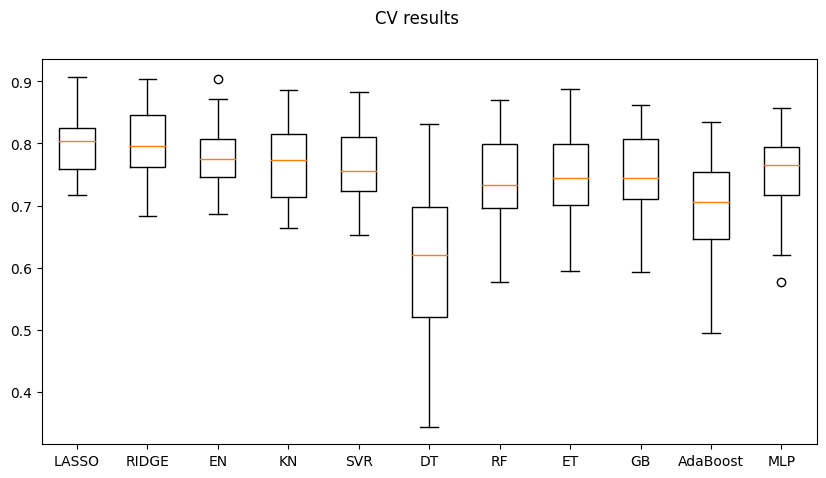

In [21]:
# Evaluate cross-validation results
fig = plt.figure()
fig.suptitle('CV results')
ax = fig.add_subplot(111)
plt.boxplot(search_results["cv_results"], labels=search_results["name"])
fig.set_size_inches((10, 5))
plt.show()

The results continue to be very similar and <code>LASSO</code> and <code>RIDGE</code> have no outliers in the cross-validation analysis and the distribution has a symmetric shape.

Let's see better the distribution of the residuals. Taking into account the similarities, the model with a residuals distribution closer to a normal one, will be the winner.

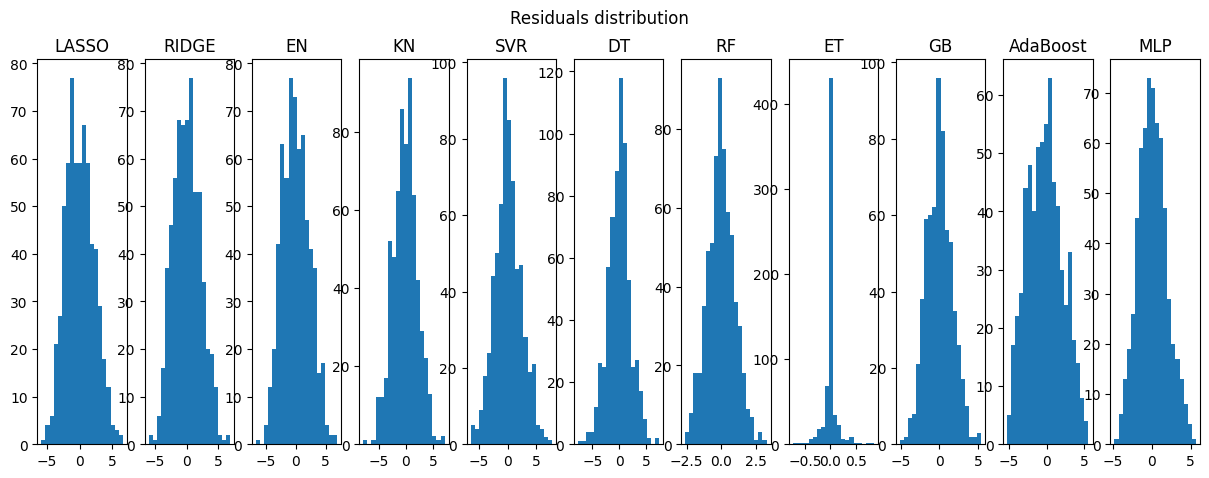

In [23]:
# Check residuals
data_residuals = search_results[["name", "residuals"]]
fig, ax = plt.subplots(1, len(search_results))
fig.suptitle('Residuals distribution')

i = 0
for _, row in data_residuals.iterrows():
    ax[i].hist(x=row["residuals"], bins=20)
    ax[i].set_title(row["name"])
    i += 1

fig.set_size_inches((15, 5))
plt.show()


In [24]:
# Check skewness and kurtosis
for _, row in data_residuals.iterrows():
    skewness = skew(row["residuals"])
    kurto = kurtosis(row["residuals"])
    print(f"{row['name']}: skewness={skewness}, kurtosis={kurto}")

LASSO: skewness=0.2295704612770886, kurtosis=-0.37987043959929423
RIDGE: skewness=0.1932644284103005, kurtosis=-0.2830271794963415
EN: skewness=0.20798196106069033, kurtosis=-0.3479359162232236
KN: skewness=-0.005623034243595195, kurtosis=0.03594137460096425
SVR: skewness=0.10241874845564083, kurtosis=0.07454169404897382
DT: skewness=-0.016335958517538326, kurtosis=0.6085254401947884
RF: skewness=0.1366360559669948, kurtosis=0.030805747008875173
ET: skewness=0.5033873544968015, kurtosis=11.76956522995579
GB: skewness=0.17661497572687207, kurtosis=0.016870546207008896
AdaBoost: skewness=0.13960632008507415, kurtosis=-0.6570865543668769
MLP: skewness=0.18745136834054524, kurtosis=-0.1860992468805418


Considering the better approach to a normal distribution of the residuals, we decide to use <code>RIDGE</code> as the best model.

## 4. Predict values from the blind dataset

Finally, we can apply our best model to predict the values of the target in the blind test dataset. It is important to standarize the features before using the model. We store the values in a CSV file.

In [25]:
# Use the same estimator for the blind test
model = search_results.loc[search_results["name"] == "RIDGE", "best_estimator"].item()
data_blind_test_standard = scaler.transform(data_blind_test[best_features_names])
blind_results = pd.DataFrame({"target_pred": model.predict(data_blind_test_standard)})
blind_results.to_csv(Path("../results/blind_pred.csv"))
blind_results

,target_pred
0,15.157008
1,13.428442
2,15.153991
3,13.875020
4,15.123865
...,...
195,14.976919
196,13.786855
197,10.662689
198,13.493779


We do not have data to compare with, but we can check if the distribution obtained for the blind test dataset comes from the same population as the training dataset. It is also a way to see that we are not suffering overfitting.

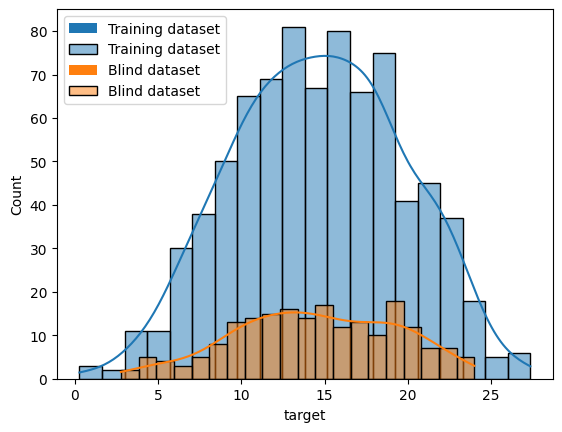

In [26]:
# Compare both distributions
sns.histplot(data=y_data, bins=20, label="Training dataset", kde=True)
sns.histplot(data=blind_results["target_pred"], bins=20, label="Blind dataset", kde=True)
plt.legend()
plt.show()

We define a function to calculate the Z-test. It is used to compare two normal distributions.

In [27]:
def z_test_score(sample_1: list, sample_2: list, difference: float = 0.0) -> float:
    mean_1 = np.mean(sample_1)
    mean_2 = np.mean(sample_2)
    std_1 = np.std(sample_1)
    std_2 = np.std(sample_2)
    n_1 = len(sample_1)
    n_2 = len(sample_2)
    z_score = ((mean_1 - mean_2) - difference) / np.sqrt((std_1 ** 2 / n_1) + (std_2 ** 2 / n_2))
    p_value = 2.0 * (1.0 - norm.cdf(np.abs(z_score)))
    return z_score, p_value

In the Z-test, the null hypothesis states that there is no significant differences between samples. If the p-value is higher than 0.05, we cannot reject the null hypothesis and we will consider that both samples belong to the same population.

In [28]:
# Compare both distributions using Z-test
z_score, p_value = z_test_score(y_data.to_list(), blind_results["target_pred"].to_list())
print(f"Z-score = {z_score}")
print(f"p-value = {p_value}")


Z-score = 0.46120515431865233
p-value = 0.6446514240729118


The p-value is much higher than 0.05, therefore the training target values and the obtained blind target values belong to the same population.